# Example of Metric Learning in Embedded Space

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# System imports
import os
import sys
import yaml

# External imports
import matplotlib.pyplot as plt
import scipy as sp
from sklearn.decomposition import PCA
from sklearn.metrics import auc
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from pytorch_lightning.loggers import TensorBoardLogger, WandbLogger
from pytorch_lightning import Trainer
import frnn

sys.path.append('../..')

from LightningModules.Embedding.Models.layerless_embedding import LayerlessEmbedding
import copy
from LightningModules.Embedding.utils import build_edges, graph_intersection

device = "cuda" if torch.cuda.is_available() else "cpu"

## Pytorch Lightning Model

In [5]:
with open("example_embedding.yaml") as f:
        hparams = yaml.load(f, Loader=yaml.FullLoader)

We plug these parameters into a constructor of the `LayerlessEmbedding` Lightning Module. This doesn't **do** anything yet - merely creates the object.

In [6]:
model = LayerlessEmbedding(hparams)

## The Dataset

To load the data, we call a `setup` method. There is some flexibility in how to handle data, and one should check the Pytorch Lightning docs to see the spectrum of options. This is my favourite way: Hide all of the data loading inside the Lightning module. We are explicitly calling `setup` here because we're going to visualise some of the data first. In future, once you know the nature of the data, we can skip this step, since the trainer will call this automatically when it starts training. 

NOTE: This may take a minute or two, since the data is being trimmed to particles above a certain momentum threshold.

In [13]:
%%time
model.setup(stage="fit")

CPU times: user 14.4 ms, sys: 14.2 ms, total: 28.6 ms
Wall time: 66.7 ms


### Visualise geometry

Just as a sanity check, let's look directly at the geometry of the data, as well as some distributions. This is just to make sure that, e.g. it's normalised in some reasonable way (that is, it doesn't vary from -1000 to +1000 or some large numbers, but that it is distributed close to +1 and -1 - this makes training much more effective!), and there aren't weird outliers (this also damages training!). 

In [14]:
trainset = model.trainset

In [15]:
example_data = trainset[0]
r, phi, z = example_data.x.T

In [16]:
x, y = r*np.cos(phi*np.pi)*1000, r*np.sin(phi*np.pi)*1000
z = z*1000

(Text(0.5, 1.0, 'Down-beampipe Spacepoint Distribution'),
 Text(0.5, 0, 'x direction (mm)'),
 Text(0, 0.5, 'y direction (mm)'))

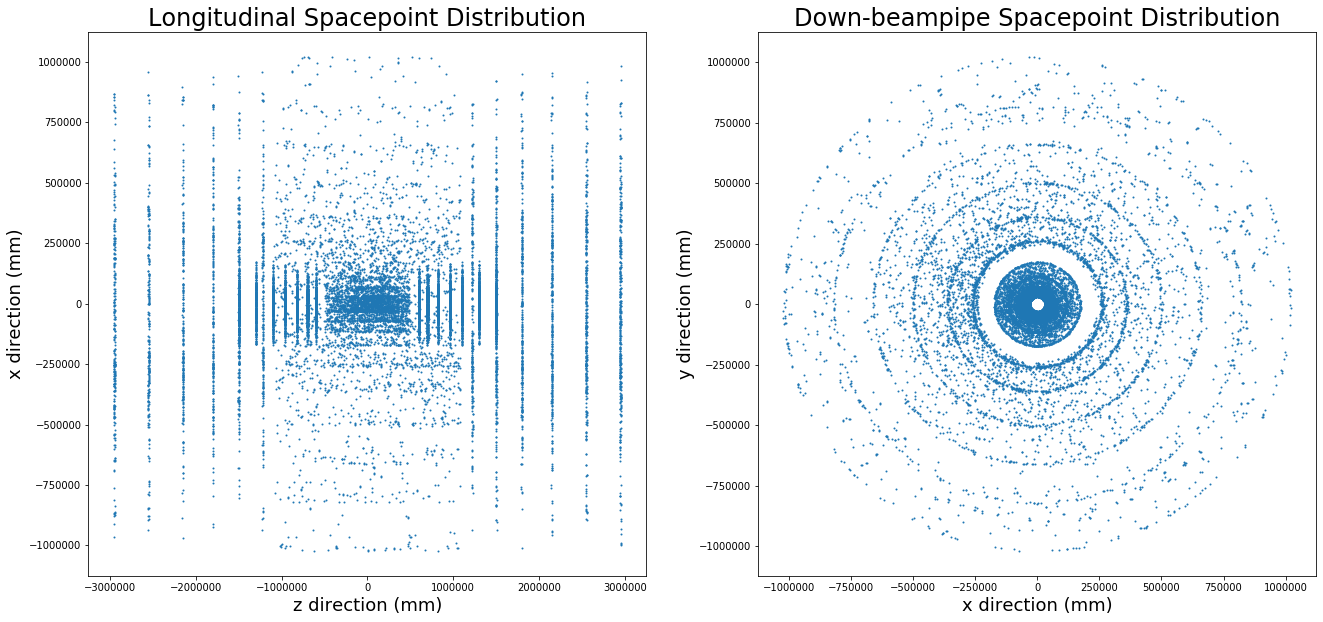

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(22,10))
axs[0].scatter(z, x, s=1)
axs[1].scatter(x, y, s=1)
axs[0].set_title("Longitudinal Spacepoint Distribution", fontsize=24), axs[0].set_xlabel("z direction (mm)", fontsize=18), axs[0].set_ylabel("x direction (mm)", fontsize=18)
axs[1].set_title("Down-beampipe Spacepoint Distribution", fontsize=24), axs[1].set_xlabel("x direction (mm)", fontsize=18), axs[1].set_ylabel("y direction (mm)", fontsize=18)

### Visualise distributions

Observe the hard cut-off below 1GeV - this is because we are ignoring lower energy hits to keep things easy for now. But we should include them again once we are happy with our ML architecture!

In [19]:
particle_num, particle_counts = np.unique(example_data.pid.numpy(), return_counts = True)

In [20]:
particle_num, particle_counts

(array([  4503599694479360,   4503599711256576,   4503599761588224, ...,
        153150976377749504, 153150976394526720, 153157573682462721]),
 array([10,  4,  8, ...,  8,  8,  1]))

Number of particles: 1720


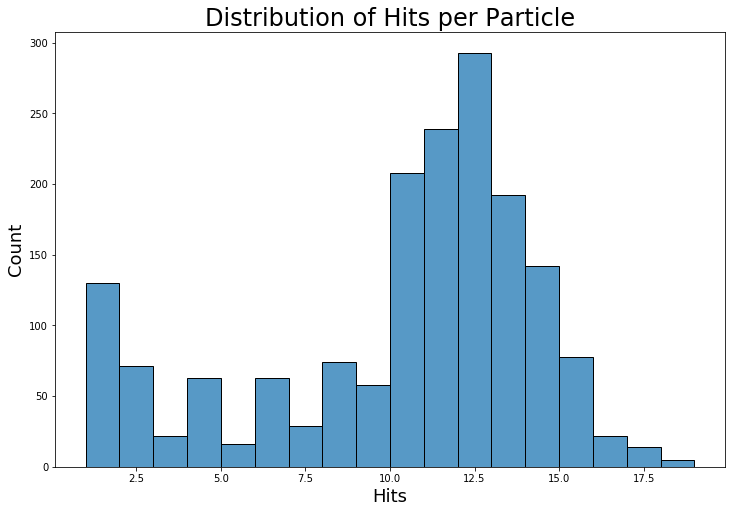

In [21]:
plt.figure(figsize=(12,8))
sns.histplot(particle_counts[1:], binwidth=1)
plt.title("Distribution of Hits per Particle", fontsize=24), plt.xlabel("Hits", fontsize=18), plt.ylabel("Count", fontsize=18)
print("Number of particles:", len(particle_num))

This gives an idea about how long each particle track is. We can see that most particle tracks leave > 10 hits, which will be useful for our graph neural networks down the track. In general, shorter tracks are harder to detect, and less useful for doing meaningful physics.

## Metric Learning

### Train embedding

Finally! Let's train! We instantiate a `Trainer` class that knows things like which hardware to work with, how long to train for, and a **bunch** of default options that we ignore here. Check out the Trainer class docs in Pytorch Lightning. Suffice it to say that it clears away much repetitive boilerplate in training code.

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    monitor='eff',
    mode="max",
    save_top_k=2,
    save_last=True)

In [8]:
logger = WandbLogger(project=hparams["project"], group="InitialTest")
trainer = Trainer(gpus=1, max_epochs=hparams["max_epochs"], logger=logger, num_sanity_val_steps=0, callbacks=[checkpoint_callback])
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: murnanedaniel (use `wandb login --relogin` to force relogin)


Set SLURM handle signals.

  | Name      | Type       | Params
-----------------------------------------
0 | layers    | ModuleList | 5.3 M 
1 | emb_layer | Linear     | 8.2 K 
2 | norm      | LayerNorm  | 2.0 K 
3 | act       | Tanh       | 0     
-----------------------------------------
5.3 M     Trainable params
0         Non-trainable params
5.3 M     Total params
21.049    Total estimated model params size (MB)
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/data_loading.py:106: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 80 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  f"The dataloader, {name}, does not have many workers which may be a bottleneck."
/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/dat

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

../../LightningModules/Embedding/embedding_base.py:275: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  eff = torch.tensor(cluster_true_positive / cluster_true)
../../LightningModules/Embedding/embedding_base.py:276: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pur = torch.tensor(cluster_true_positive / cluster_positive)


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/global/homes/d/danieltm/.conda/envs/exatrkx-test/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:1051: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [10]:
model = model.to(device)

In [38]:
results = model.shared_evaluation(model.valset[0].to(device), 0, 1.6, 1000)

In [39]:
results["truth"].sum() / results["truth_graph"].shape[1], results["truth"].sum() / results["preds"].shape[1]

(tensor(0.9908), tensor(0.0082))

### Test embedding

A Pytorch Lightning Trainer has two main methods: `fit` and `test`. They represent the two main steps of any ML engingeering or research: Train a model, then make sure it can infer accurately on test (i.e. **hidden**) data.

Note that `ckpt_path` just tells the trainer to use the latest "checkpoint" of the model, rather than *best* checkpoint. A checkpoint is a saved version of the model, a snapshot at a particular stage of the training process. Pytorch Lightning automatically saves a checkpoint of your model in case something crashes and we need to resume.

In [23]:
test_results = trainer.test(ckpt_path=None)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9709646701812744,
 'pur': 0.055771585553884506,
 'val_loss': 0.9984596371650696}
--------------------------------------------------------------------------------


## Performance

In [13]:
from LightningModules.Embedding.utils import get_metrics

Let's see how well the model learned to embed the hits into a space that separates them into discrete clusters. As in the data visualisation above, we are going manual here. So one thing we need to do is tell the model that we are **evaluating**, not **training**, with `model.eval()`. We also make sure to wrap everything with `with torch.no_grad()` to ignore any gradients. This speeds things up and gives the GPU's memory a rest, since we're not interesting in any kind of training from here on in.

In [24]:
model.eval();

### Test metrics

In [27]:
all_efficiencies, all_purities = [], []
all_radius = np.arange(0.5, 1.2, 0.1)

with torch.no_grad():
    for r in all_radius:

        model.hparams.r_test = r
        test_results = trainer.test(ckpt_path=None)[0]

        mean_efficiency, mean_purity = test_results["eff"], test_results["pur"]

        all_efficiencies.append(mean_efficiency)
        all_purities.append(mean_purity)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.29412952065467834,
 'pur': 0.31158846616744995,
 'val_loss': 0.8040090799331665}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.5026120543479919,
 'pur': 0.3214113712310791,
 'val_loss': 0.828713059425354}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.6482229828834534,
 'pur': 0.2828279137611389,
 'val_loss': 0.8727149963378906}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.745759904384613,
 'pur': 0.23499229550361633,
 'val_loss': 0.9117689728736877}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8200681805610657,
 'pur': 0.18902744352817535,
 'val_loss': 0.9429423809051514}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.8717353343963623,
 'pur': 0.15006624162197113,
 'val_loss': 0.9644220471382141}
--------------------------------------------------------------------------------



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'current_lr': 0.0005999999702908099,
 'eff': 0.9083821177482605,
 'pur': 0.12099817395210266,
 'val_loss': 0.9782997965812683}
--------------------------------------------------------------------------------


We should always visualise two important metrics: the efficiency (the number of true positives divided by the total number of possible true edges) and the purity (the number of true positives divided by the number of predicted edges). Is it clear to you why the graphs below behave as they do, as we widen the sphere around each hit to generate neighboring edges?

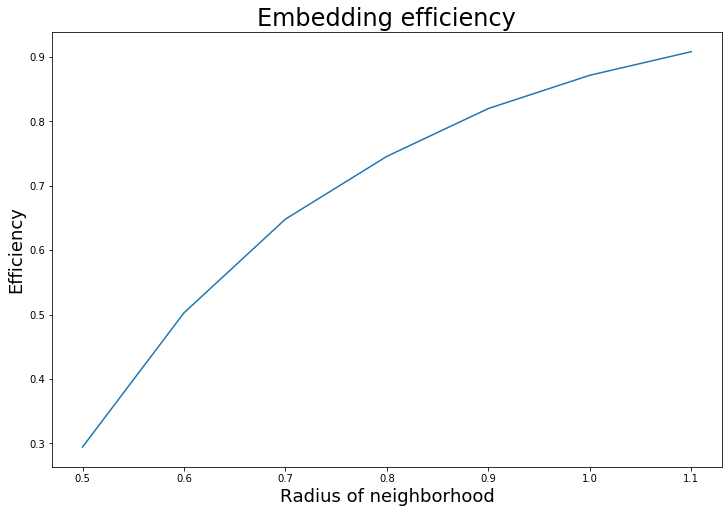

In [28]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_efficiencies);
plt.title("Embedding efficiency", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Efficiency", fontsize=18);

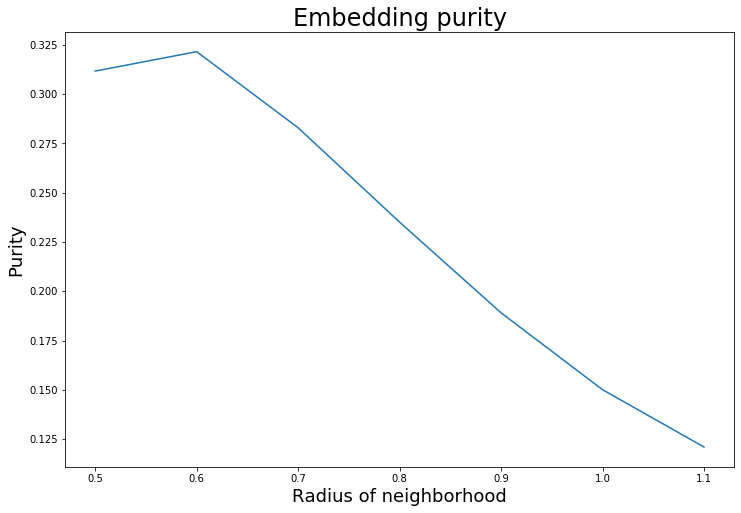

In [29]:
plt.figure(figsize=(12,8))
plt.plot(all_radius, all_purities);
plt.title("Embedding purity", fontsize=24), plt.xlabel("Radius of neighborhood", fontsize=18), plt.ylabel("Purity", fontsize=18);

### Visualise embedding / latent space

Another useful thing to visualise is the actual space being embedded into. Since it's 8 dimensional, we can reduce it to 2 dimensions with "Principal Component Analysis". 

In [24]:
from sklearn.decomposition import PCA

In [25]:
example_data = trainset[0]
particle_ids = example_data.pid
cyl_coords = example_data.x
cell_features = example_data.cell_data
all_features = torch.cat([cyl_coords, cell_features], axis=-1).to("cuda")

In [26]:
latent_features = model(all_features)

In [27]:
pca = PCA(n_components=2)

In [28]:
reduced_dimensions = pca.fit_transform(latent_features.detach().cpu())

In [29]:
reduced_dimensions

array([[-8.95513417, -3.68551328],
       [-9.26373197, -2.57803677],
       [17.49976278,  3.70361098],
       ...,
       [16.35837063, -5.6276739 ],
       [17.72111695, -4.57634675],
       [13.94139828, -8.52278351]])

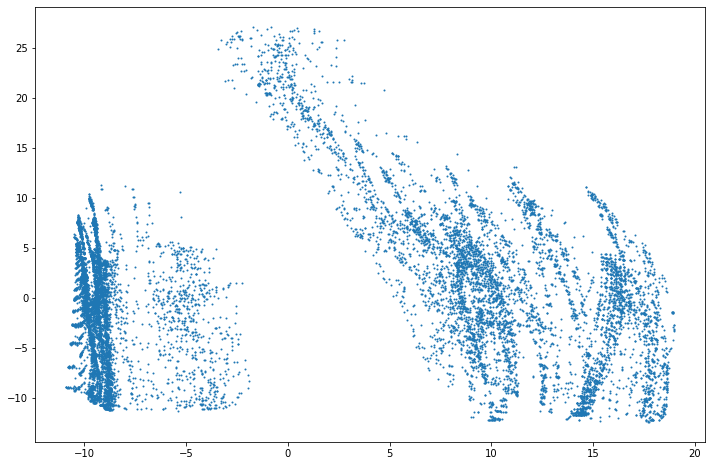

In [30]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)

The above plot is what **all** the data looks like in the latent space. Let's pick a (long) particle track and see if the track is projected to be close together:

In [31]:
particles, counts = np.unique(example_data.pid, return_counts=True)

In [32]:
example_particle = particles[counts > 10][0]

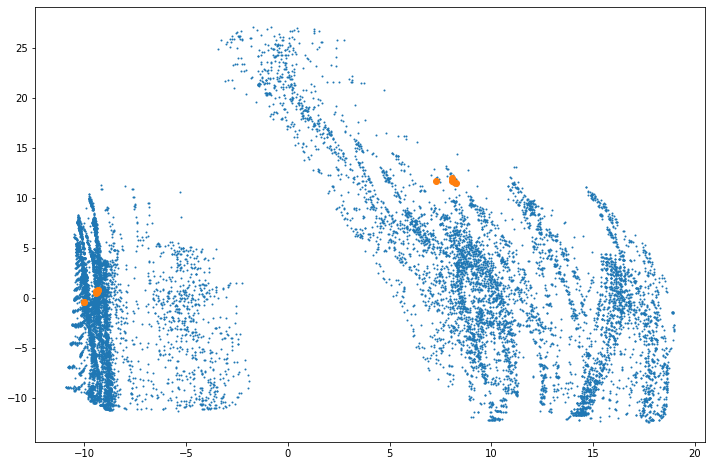

In [33]:
plt.figure(figsize=(12,8))
plt.scatter(reduced_dimensions[:, 0], reduced_dimensions[:, 1], s=1)
plt.scatter(reduced_dimensions[particle_ids == example_particle, 0], reduced_dimensions[particle_ids == example_particle, 1])

There are at least 10 hits in the plot above. Hopefully some of them cluster together into blobs, and that the blobs are close to other blobs of the same color. We get ~99% efficiency with this model, so even if some blobs appear far away in the PCA-reduced 2D space, they are most likely much closer in the 8-dimensional space. You can check this yourself!

### Distributions

In [7]:
def calc_eta(r, z):
    theta = np.arctan2(r, z)
    return -1. * np.log(np.tan(theta / 2.))

In [7]:
def get_performance(model, batch, r_max, k_max):
    with torch.no_grad():
        input_data = torch.cat([batch.cell_data[:, :model.hparams["cell_channels"]], batch.x], axis=-1)
        input_data[input_data != input_data] = 0
        spatial = model(input_data)
        e_bidir = torch.cat(
                [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
            )
        e_spatial = build_edges(spatial, spatial, indices=None, r_max=r_max, k_max=k_max)
        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)
    
    return y_cluster, e_spatial, e_bidir

In [37]:
r_max = 1.6
k_max = 1100

In [38]:
%%time
batch = 0
model.eval()

y_cluster, e_spatial, e_bidir = get_performance(model, model.testset[batch].to(device), r_max=r_max, k_max=k_max)

CPU times: user 12.2 s, sys: 7.56 s, total: 19.8 s
Wall time: 18.9 s


In [28]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.0007887072279118001, Eff: 0.9454706311225891


In [39]:
print(f"Pur: {y_cluster.sum() / y_cluster.shape[0]}, Eff: {y_cluster.sum() / e_bidir.shape[1]}")

Pur: 0.0011381200747564435, Eff: 0.9444215893745422


In [40]:
torch.cuda.max_memory_allocated() / 1024**3

7.769199371337891

In [35]:
torch.cuda.reset_peak_memory_stats()

In [12]:
eta_cuts = np.arange(-4, 4.5, 0.5)
batch_range = np.arange(0,200)

eta_eff_list = []
eta_pur_list = []

for batch_idx in batch_range[:5]:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=r_max, k_max=k_max)
    
    eta_hits = calc_eta(batch.x[:, 0].cpu(), batch.x[:, 2].cpu())
    av_eta_preds = (eta_hits[e_spatial[0]] + eta_hits[e_spatial[1]])/2
    av_eta_true = (eta_hits[e_bidir[0]] + eta_hits[e_bidir[1]])/2
    
    for eta1, eta2 in zip(eta_cuts[:-1], eta_cuts[1:]):
        edge_eta_pred = (av_eta_preds >= eta1) & (av_eta_preds <= eta2)
        edge_eta_true = (av_eta_true >= eta1) & (av_eta_true <= eta2)
        true_positives = y_cluster[edge_eta_pred]

        eta_eff_list.append(true_positives.sum().item() / edge_eta_true.sum().item())
        eta_pur_list.append(true_positives.sum().item() / true_positives.shape[0])

RuntimeError: CUDA out of memory. Tried to allocate 1.52 GiB (GPU 0; 15.78 GiB total capacity; 11.62 GiB already allocated; 1.49 GiB free; 12.93 GiB reserved in total by PyTorch)

In [ ]:
eta_eff_reshape = np.array(eta_eff_list).reshape(eta_cuts.shape[0]-1, len(batch_range))
eta_pur_reshape = np.array(eta_pur_list).reshape(eta_cuts.shape[0]-1, len(batch_range))

Train set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

Test set

In [ ]:
plt.scatter(eta_eff_reshape.mean(0), eta_pur_reshape.mean(0), s=2)

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_eff_reshape.mean(1), eta_eff_reshape.std(1), fmt="o")

In [ ]:
eta_center = (eta_cuts[:-1] + eta_cuts[1:])/2
plt.errorbar(eta_center, eta_pur_reshape.mean(1), eta_pur_reshape.std(1), fmt="o")

In [ ]:
pt_cuts = np.arange(900, 5000, 500)

pt_eff_list = []
pt_pur_list = []
    
for batch_idx in batch_range:
    
    batch = model.testset[batch_idx].to(device)
    
    y_cluster, e_spatial, e_bidir = get_performance(model, batch, r_max=1.2, k_max=500)
    
    av_pt_preds = (batch.pt[e_spatial[0]] + batch.pt[e_spatial[1]])/2
    av_pt_true = (batch.pt[e_bidir[0]] + batch.pt[e_bidir[1]])/2
    
    for pt1, pt2 in zip(pt_cuts[:-1], pt_cuts[1:]):
        edge_pt_pred = (av_pt_preds >= pt1) & (av_pt_preds <= pt2)
        edge_pt_true = (av_pt_true >= pt1) & (av_pt_true <= pt2)
        true_positives = y_cluster[edge_pt_pred]

        pt_eff_list.append(true_positives.sum().item() / max(1, edge_pt_true.sum().item()))
        pt_pur_list.append(true_positives.sum().item() / max(1, true_positives.shape[0]))
    

In [ ]:
pt_eff_reshape = np.array(pt_eff_list).reshape(pt_cuts.shape[0]-1, len(batch_range))
pt_pur_reshape = np.array(pt_pur_list).reshape(pt_cuts.shape[0]-1, len(batch_range))

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_eff_reshape.mean(1), pt_eff_reshape.std(1), fmt="o")

In [ ]:
pt_center = (pt_cuts[:-1] + pt_cuts[1:])/2
plt.errorbar(pt_center, pt_pur_reshape.mean(1), pt_pur_reshape.std(1), fmt="o")

## Memory of Edge Builder

In [29]:
torch.cuda.max_memory_allocated() / 1024**3

4.934445381164551

In [26]:
torch.cuda.reset_peak_memory_stats()

In [8]:
r_max = 1.6
k_max = 1000

In [9]:
batch = model.testset[0].to(device)
model.eval()
with torch.no_grad():
    input_data = torch.cat([batch.cell_data[:, :model.hparams["cell_channels"]], batch.x], axis=-1)
    input_data[input_data != input_data] = 0
    spatial = model(input_data)
    e_bidir = torch.cat(
            [batch.modulewise_true_edges, batch.modulewise_true_edges.flip(0)], axis=-1
        )

In [11]:
dists, idxs, nn, grid = frnn.frnn_grid_points(points1=spatial.unsqueeze(0), points2=spatial.unsqueeze(0), lengths1=None, lengths2=None, K=k_max, r=r_max, grid=None, return_nn=False, return_sorted=True)

In [13]:
idxs = idxs.squeeze().int()
ind = torch.Tensor.repeat(torch.arange(idxs.shape[0], device=device), (idxs.shape[1], 1), 1).T.int()

In [15]:
positive_idxs = idxs >= 0
ind = ind[positive_idxs]
idxs = idxs[positive_idxs]

In [17]:
edge_list = torch.stack([ind, idxs]).int()

In [19]:
# Remove self-loops
edge_list = edge_list[:, edge_list[0] != edge_list[1]]

In [24]:
del ind
del idxs

In [28]:
edge_list = edge_list.long()

# Build Edge Dataset

## Load best model

In [16]:
checkpoint_path = "/global/cscratch1/sd/danieltm/ExaTrkX/itk_lightning_checkpoints/ITk_1GeV/pdwlz89x/checkpoints/last.ckpt"
checkpoint = torch.load(checkpoint_path)

In [17]:
model = LayerlessEmbedding.load_from_checkpoint(checkpoint_path).to(device)

In [18]:
model.hparams["train_split"] = [10, 10, 10]

In [19]:
%%time
model.setup(stage="fit")

KeyError: 'pt_background_min'

## Define Building Class

In [7]:
class EmbeddingInferenceBuilder:
    def __init__(self, model, output_dir, overwrite=False):
        self.output_dir = output_dir
        self.model = model
        self.overwrite = overwrite

        # Prep the directory to produce inference data to
        self.datatypes = ["train", "val", "test"]
        os.makedirs(self.output_dir, exist_ok=True)
        [
            os.makedirs(os.path.join(self.output_dir, datatype), exist_ok=True)
            for datatype in self.datatypes
        ]


    def build(self):
        print("Training finished, running inference to build graphs...")

        # By default, the set of examples propagated through the pipeline will be train+val+test set
        datasets = {
            "train": self.model.trainset,
            "val": self.model.valset,
            "test": self.model.testset,
        }
        total_length = sum([len(dataset) for dataset in datasets.values()])
        batch_incr = 0
        self.model.eval()
        with torch.no_grad():
            for set_idx, (datatype, dataset) in enumerate(datasets.items()):
                for batch_idx, batch in enumerate(dataset):
                    percent = (batch_incr / total_length) * 100
                    sys.stdout.flush()
                    sys.stdout.write(f"{percent:.01f}% inference complete \r")
                    if (
                        not os.path.exists(
                            os.path.join(
                                self.output_dir, datatype, batch.event_file[-4:]
                            )
                        )
                    ) or self.overwrite:
                        batch_to_save = copy.deepcopy(batch)
                        batch_to_save = batch_to_save.to(
                            self.model.device
                        )  # Is this step necessary??
                        self.construct_downstream(batch_to_save, datatype)

                    batch_incr += 1

    def construct_downstream(self, batch, datatype):

        if "ci" in self.model.hparams["regime"]:
            input_data = torch.cat([batch.cell_data[:, :self.model.hparams["cell_channels"]], batch.x], axis=-1)
            input_data[input_data != input_data] = 0
            spatial = self.model(input_data)
        else:
            input_data = batch.x
            input_data[input_data != input_data] = 0
            spatial = self.model(input_data)

        # Make truth bidirectional
        e_bidir = torch.cat(
            [
                batch.modulewise_true_edges,
                torch.stack(
                    [batch.modulewise_true_edges[1], batch.modulewise_true_edges[0]],
                    axis=1,
                ).T,
            ],
            axis=-1,
        )

        # Build the radius graph with radius < r_test
        e_spatial = build_edges(
            spatial, spatial, indices=None, r_max=self.model.hparams["r_test"], k_max =1100
        ).long()  # This step should remove reliance on r_val, and instead compute an r_build based on the EXACT r required to reach target eff/pur

        # Arbitrary ordering to remove half of the duplicate edges
        R_dist = torch.sqrt(batch.x[:, 0] ** 2 + batch.x[:, 2] ** 2)
        e_spatial = e_spatial[:, (R_dist[e_spatial[0]] <= R_dist[e_spatial[1]])]

        e_spatial, y_cluster = graph_intersection(e_spatial, e_bidir)

        # Re-introduce random direction, to avoid training bias
        random_flip = torch.randint(2, (e_spatial.shape[1],)).bool()
        e_spatial[0, random_flip], e_spatial[1, random_flip] = (
            e_spatial[1, random_flip],
            e_spatial[0, random_flip],
        )

        batch.edge_index = e_spatial
        batch.y = y_cluster

        self.save_downstream(batch, datatype)

    def save_downstream(self, batch, datatype):

        with open(
            os.path.join(self.output_dir, datatype, batch.event_file[-4:]), "wb"
        ) as pickle_file:
            torch.save(batch, pickle_file)


In [10]:
output_dir = "/project/projectdirs/m3443/data/ITk-upgrade/processed/embedding_processed/0_GeV_unweighted_subset"
model.hparams["r_test"] = 1.6
edge_builder = EmbeddingInferenceBuilder(model, output_dir, overwrite=False)

In [11]:
edge_builder.build()

Training finished, running inference to build graphs...


In [13]:
len(model.trainset)

100